# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

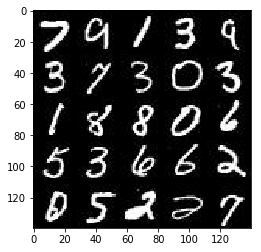

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

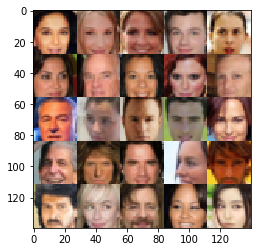

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,shape=[None,image_width,image_height,image_channels],name='input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.2
        #28x28x3
        x1 = tf.layers.conv2d(images,128,5,strides=2,padding='same')
        x1 = tf.maximum(alpha*x1,x1)
        #14x14x64
        x2 = tf.layers.conv2d(x1,256,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2= tf.maximum(alpha*x2,x2)
        #7x7x128
        x3 = tf.layers.conv2d(x2,512,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,training=True)
        x3= tf.maximum(alpha*x3,x3)
        
        #3x3x256
        shape = x3.get_shape().as_list()
        flat = tf.reshape(x3,[-1,shape[1]*shape[2]*shape[3]])
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        alpha = 0.02
        x1 = tf.layers.dense(z,7*7*512)
        
        
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
        
        #7x7x512
        x2 = tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2= tf.maximum(alpha*x2,x2)
        
        #14x14x256
        x3 = tf.layers.conv2d_transpose(x2,128,5,strides=1,padding='same')
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3= tf.maximum(alpha*x3,x3)
        
        #28x28xoutputdim
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides=2,padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real,d_logits_real = discriminator(input_real)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_logits_real)))
    
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_real)))
    
    d_loss  = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real,input_z,lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss,g_loss = model_loss(input_real,input_z,data_shape[3])
    d_train_opt,g_train_opt = model_opt(d_loss,g_loss,learning_rate,beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1 
                batch_images = batch_images * 2 #(-0.5 to 0.5 to -1 to 1 )
                
                #Noise for generator
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess,10,input_z,data_shape[3],data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7172... Generator Loss: 10.4876
Epoch 1/2... Discriminator Loss: 2.2615... Generator Loss: 7.1932
Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 6.0051
Epoch 1/2... Discriminator Loss: 0.7179... Generator Loss: 0.9774
Epoch 1/2... Discriminator Loss: 0.4897... Generator Loss: 1.7835
Epoch 1/2... Discriminator Loss: 2.9281... Generator Loss: 0.0950
Epoch 1/2... Discriminator Loss: 3.4399... Generator Loss: 6.5913
Epoch 1/2... Discriminator Loss: 1.1097... Generator Loss: 3.3777
Epoch 1/2... Discriminator Loss: 0.5657... Generator Loss: 1.5238
Epoch 1/2... Discriminator Loss: 0.7354... Generator Loss: 0.9723


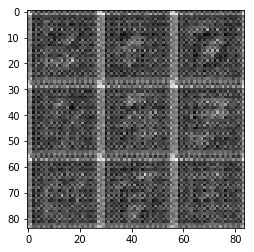

Epoch 1/2... Discriminator Loss: 0.6131... Generator Loss: 1.4206
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 2.8565
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 3.4149
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 2.9163
Epoch 1/2... Discriminator Loss: 0.5571... Generator Loss: 1.6634
Epoch 1/2... Discriminator Loss: 0.7819... Generator Loss: 2.9348
Epoch 1/2... Discriminator Loss: 0.5062... Generator Loss: 2.1046
Epoch 1/2... Discriminator Loss: 0.5473... Generator Loss: 1.5708
Epoch 1/2... Discriminator Loss: 0.9260... Generator Loss: 2.9785
Epoch 1/2... Discriminator Loss: 0.5348... Generator Loss: 2.1456


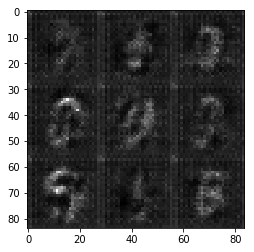

Epoch 1/2... Discriminator Loss: 0.5432... Generator Loss: 1.3630
Epoch 1/2... Discriminator Loss: 0.6364... Generator Loss: 2.5872
Epoch 1/2... Discriminator Loss: 0.5318... Generator Loss: 1.8202
Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 2.0822
Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.2903
Epoch 1/2... Discriminator Loss: 0.4870... Generator Loss: 1.6077
Epoch 1/2... Discriminator Loss: 0.6372... Generator Loss: 2.8083
Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 2.6630
Epoch 1/2... Discriminator Loss: 0.5024... Generator Loss: 1.6079
Epoch 1/2... Discriminator Loss: 0.5107... Generator Loss: 1.2814


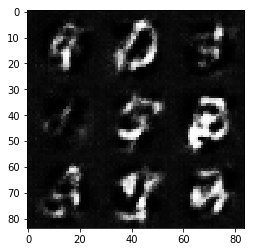

Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 0.6102
Epoch 1/2... Discriminator Loss: 0.4890... Generator Loss: 1.4229
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 0.4683
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 0.7732
Epoch 1/2... Discriminator Loss: 0.4386... Generator Loss: 1.7460
Epoch 1/2... Discriminator Loss: 0.4964... Generator Loss: 1.6682
Epoch 1/2... Discriminator Loss: 0.5388... Generator Loss: 1.6987
Epoch 1/2... Discriminator Loss: 0.6132... Generator Loss: 2.0668
Epoch 1/2... Discriminator Loss: 0.5620... Generator Loss: 1.3083


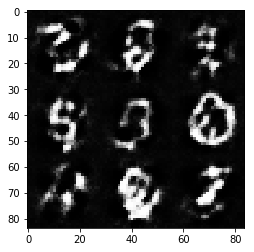

Epoch 1/2... Discriminator Loss: 1.1771... Generator Loss: 0.5049
Epoch 1/2... Discriminator Loss: 0.5699... Generator Loss: 2.4068
Epoch 1/2... Discriminator Loss: 1.5871... Generator Loss: 0.3546
Epoch 1/2... Discriminator Loss: 0.5503... Generator Loss: 1.2262
Epoch 1/2... Discriminator Loss: 0.7903... Generator Loss: 0.7356
Epoch 1/2... Discriminator Loss: 0.7653... Generator Loss: 0.9086
Epoch 1/2... Discriminator Loss: 0.7776... Generator Loss: 0.8199
Epoch 1/2... Discriminator Loss: 0.6184... Generator Loss: 1.1415
Epoch 1/2... Discriminator Loss: 0.5180... Generator Loss: 1.4821
Epoch 1/2... Discriminator Loss: 0.6797... Generator Loss: 2.5506


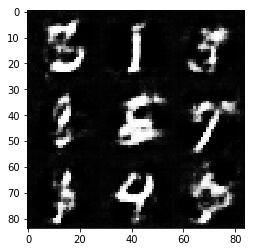

Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 0.5081
Epoch 1/2... Discriminator Loss: 0.5536... Generator Loss: 1.3634
Epoch 1/2... Discriminator Loss: 0.6320... Generator Loss: 2.0863
Epoch 1/2... Discriminator Loss: 0.6262... Generator Loss: 1.3416
Epoch 1/2... Discriminator Loss: 2.0299... Generator Loss: 0.2002
Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 0.5384
Epoch 1/2... Discriminator Loss: 0.7474... Generator Loss: 0.8761
Epoch 1/2... Discriminator Loss: 0.9457... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 0.8274... Generator Loss: 0.8086
Epoch 1/2... Discriminator Loss: 0.5479... Generator Loss: 1.4494


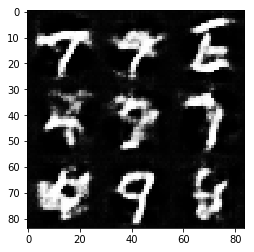

Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 2.8997
Epoch 1/2... Discriminator Loss: 0.6481... Generator Loss: 1.0478
Epoch 1/2... Discriminator Loss: 0.8619... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 0.7756... Generator Loss: 0.8648
Epoch 1/2... Discriminator Loss: 0.9257... Generator Loss: 2.4615
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 1.8342
Epoch 1/2... Discriminator Loss: 0.6979... Generator Loss: 0.9590
Epoch 1/2... Discriminator Loss: 1.1712... Generator Loss: 0.5255
Epoch 1/2... Discriminator Loss: 0.7238... Generator Loss: 1.0611
Epoch 1/2... Discriminator Loss: 0.7862... Generator Loss: 1.4530


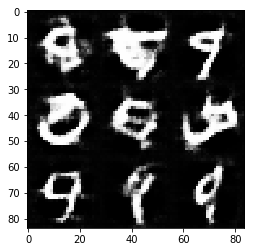

Epoch 1/2... Discriminator Loss: 0.6415... Generator Loss: 1.3907
Epoch 1/2... Discriminator Loss: 0.8408... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 0.8809... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 0.6047... Generator Loss: 1.8737
Epoch 1/2... Discriminator Loss: 1.0301... Generator Loss: 2.5603
Epoch 1/2... Discriminator Loss: 0.7248... Generator Loss: 2.0997
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 0.4206
Epoch 1/2... Discriminator Loss: 0.6565... Generator Loss: 1.1154
Epoch 1/2... Discriminator Loss: 1.3669... Generator Loss: 0.3531
Epoch 1/2... Discriminator Loss: 0.8697... Generator Loss: 1.9332


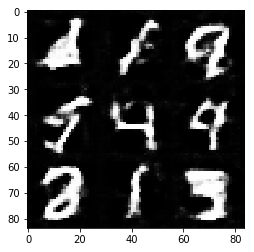

Epoch 1/2... Discriminator Loss: 0.5738... Generator Loss: 2.1997
Epoch 1/2... Discriminator Loss: 0.7118... Generator Loss: 0.9605
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 2.5858
Epoch 1/2... Discriminator Loss: 0.9917... Generator Loss: 0.6704
Epoch 1/2... Discriminator Loss: 0.8204... Generator Loss: 1.3761
Epoch 1/2... Discriminator Loss: 0.7883... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 1.5064... Generator Loss: 0.3280
Epoch 1/2... Discriminator Loss: 0.9119... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 0.6128... Generator Loss: 1.3454
Epoch 1/2... Discriminator Loss: 0.6892... Generator Loss: 1.3113


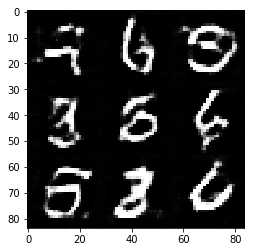

Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 2.5358
Epoch 1/2... Discriminator Loss: 0.8753... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 1.4736... Generator Loss: 0.3412
Epoch 2/2... Discriminator Loss: 0.7970... Generator Loss: 1.0814
Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 0.6497
Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 0.8955
Epoch 2/2... Discriminator Loss: 0.6518... Generator Loss: 1.0350
Epoch 2/2... Discriminator Loss: 0.6559... Generator Loss: 1.0352
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 1.0810
Epoch 2/2... Discriminator Loss: 1.2226... Generator Loss: 0.5180


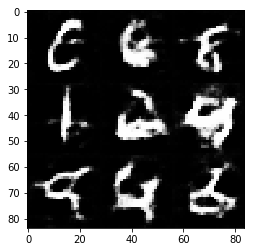

Epoch 2/2... Discriminator Loss: 0.6086... Generator Loss: 1.2526
Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 0.9245
Epoch 2/2... Discriminator Loss: 3.3534... Generator Loss: 0.1188
Epoch 2/2... Discriminator Loss: 1.0234... Generator Loss: 0.6101
Epoch 2/2... Discriminator Loss: 1.4042... Generator Loss: 0.4165
Epoch 2/2... Discriminator Loss: 0.8738... Generator Loss: 0.7994
Epoch 2/2... Discriminator Loss: 0.8122... Generator Loss: 0.8874
Epoch 2/2... Discriminator Loss: 1.6626... Generator Loss: 0.3288
Epoch 2/2... Discriminator Loss: 1.3986... Generator Loss: 0.4055
Epoch 2/2... Discriminator Loss: 0.6824... Generator Loss: 1.0250


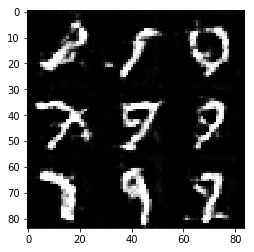

Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 0.7205
Epoch 2/2... Discriminator Loss: 0.7474... Generator Loss: 1.3251
Epoch 2/2... Discriminator Loss: 1.5026... Generator Loss: 0.3224
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 0.7337
Epoch 2/2... Discriminator Loss: 0.7535... Generator Loss: 1.0391
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.3818
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 2.0077
Epoch 2/2... Discriminator Loss: 0.7062... Generator Loss: 1.1843
Epoch 2/2... Discriminator Loss: 0.9816... Generator Loss: 0.6130
Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 2.3023


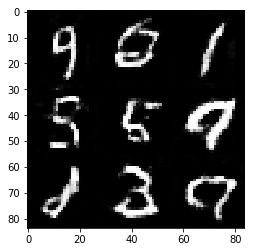

Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 0.9065... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 0.9942... Generator Loss: 0.6782
Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 0.5520
Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 0.5435
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 1.0824... Generator Loss: 1.5721
Epoch 2/2... Discriminator Loss: 0.8081... Generator Loss: 1.6753
Epoch 2/2... Discriminator Loss: 0.9722... Generator Loss: 0.7361
Epoch 2/2... Discriminator Loss: 1.1000... Generator Loss: 0.5607


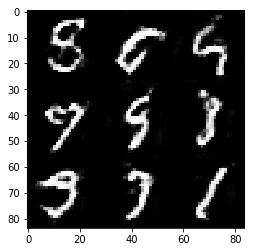

Epoch 2/2... Discriminator Loss: 0.7786... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 0.9974
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 1.6862
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 1.0807
Epoch 2/2... Discriminator Loss: 0.8870... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 0.8011... Generator Loss: 0.9210
Epoch 2/2... Discriminator Loss: 0.8398... Generator Loss: 0.7851
Epoch 2/2... Discriminator Loss: 0.8883... Generator Loss: 0.7262
Epoch 2/2... Discriminator Loss: 0.6922... Generator Loss: 1.0041
Epoch 2/2... Discriminator Loss: 4.9146... Generator Loss: 6.1162


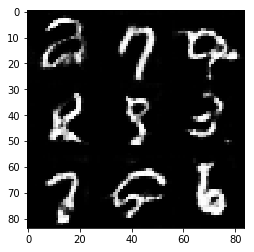

Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 0.6628
Epoch 2/2... Discriminator Loss: 0.6811... Generator Loss: 1.1635
Epoch 2/2... Discriminator Loss: 0.6817... Generator Loss: 1.0731
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.3682
Epoch 2/2... Discriminator Loss: 0.7153... Generator Loss: 0.9803
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 0.5634
Epoch 2/2... Discriminator Loss: 0.5787... Generator Loss: 1.5362
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 1.9422
Epoch 2/2... Discriminator Loss: 0.8992... Generator Loss: 0.8418
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 0.8252


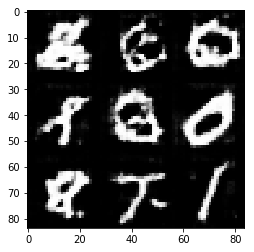

Epoch 2/2... Discriminator Loss: 0.9583... Generator Loss: 0.7459
Epoch 2/2... Discriminator Loss: 0.7540... Generator Loss: 0.9917
Epoch 2/2... Discriminator Loss: 0.7052... Generator Loss: 0.9757
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 0.5520
Epoch 2/2... Discriminator Loss: 0.6648... Generator Loss: 1.2915
Epoch 2/2... Discriminator Loss: 0.6404... Generator Loss: 1.2462
Epoch 2/2... Discriminator Loss: 0.5958... Generator Loss: 1.2912
Epoch 2/2... Discriminator Loss: 0.9834... Generator Loss: 2.6223
Epoch 2/2... Discriminator Loss: 0.6630... Generator Loss: 1.2712
Epoch 2/2... Discriminator Loss: 0.8923... Generator Loss: 0.7608


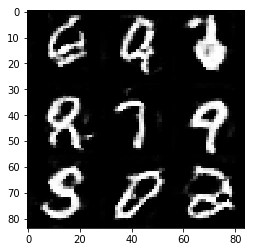

Epoch 2/2... Discriminator Loss: 0.7414... Generator Loss: 1.3815
Epoch 2/2... Discriminator Loss: 0.9979... Generator Loss: 0.6676
Epoch 2/2... Discriminator Loss: 0.4791... Generator Loss: 1.5093
Epoch 2/2... Discriminator Loss: 0.8956... Generator Loss: 1.4899
Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 0.5646
Epoch 2/2... Discriminator Loss: 0.7420... Generator Loss: 0.9428
Epoch 2/2... Discriminator Loss: 0.6653... Generator Loss: 1.2133
Epoch 2/2... Discriminator Loss: 1.2440... Generator Loss: 0.5442
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 0.5764
Epoch 2/2... Discriminator Loss: 0.6000... Generator Loss: 1.2689


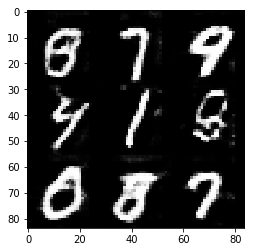

Epoch 2/2... Discriminator Loss: 0.9297... Generator Loss: 0.6838
Epoch 2/2... Discriminator Loss: 0.6600... Generator Loss: 1.1942
Epoch 2/2... Discriminator Loss: 0.7550... Generator Loss: 0.8329
Epoch 2/2... Discriminator Loss: 0.7396... Generator Loss: 1.0857
Epoch 2/2... Discriminator Loss: 1.0542... Generator Loss: 1.5593
Epoch 2/2... Discriminator Loss: 0.9265... Generator Loss: 0.8119
Epoch 2/2... Discriminator Loss: 0.7617... Generator Loss: 0.9114
Epoch 2/2... Discriminator Loss: 0.6704... Generator Loss: 1.1510
Epoch 2/2... Discriminator Loss: 1.8100... Generator Loss: 0.2325
Epoch 2/2... Discriminator Loss: 0.6757... Generator Loss: 1.1294


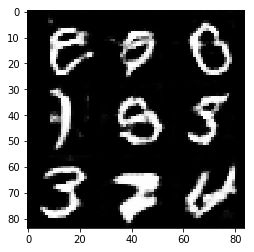

Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 0.6621
Epoch 2/2... Discriminator Loss: 1.4697... Generator Loss: 0.3415
Epoch 2/2... Discriminator Loss: 3.0683... Generator Loss: 0.1051
Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 0.8562
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 0.5287
Epoch 2/2... Discriminator Loss: 0.9337... Generator Loss: 0.7521


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 14.9491
Epoch 1/1... Discriminator Loss: 0.0665... Generator Loss: 13.6805
Epoch 1/1... Discriminator Loss: 0.3005... Generator Loss: 3.5432
Epoch 1/1... Discriminator Loss: 0.1833... Generator Loss: 4.8836
Epoch 1/1... Discriminator Loss: 0.6924... Generator Loss: 4.3224
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 1.2431
Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 0.7497... Generator Loss: 1.6753
Epoch 1/1... Discriminator Loss: 1.6310... Generator Loss: 0.3530


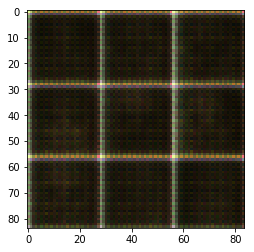

Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 3.9331
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 2.0606... Generator Loss: 0.2293
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 2.3404
Epoch 1/1... Discriminator Loss: 2.5114... Generator Loss: 0.1309
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 3.0587


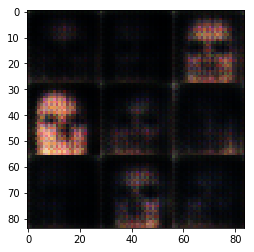

Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.9956
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 2.1908
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 2.8031
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.3850
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 1.7039... Generator Loss: 0.4210
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.6549


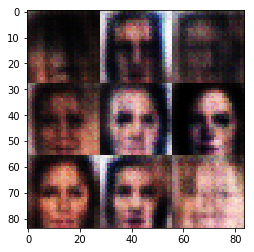

Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.8179
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 2.4596
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 1.8906
Epoch 1/1... Discriminator Loss: 2.0273... Generator Loss: 0.2343
Epoch 1/1... Discriminator Loss: 1.9448... Generator Loss: 0.3519
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 2.3313
Epoch 1/1... Discriminator Loss: 1.7418... Generator Loss: 2.2351
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 1.0647


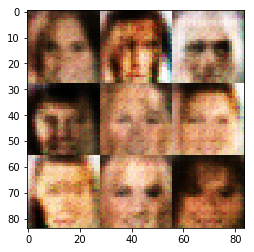

Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 3.1862
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 2.5845
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 1.7263
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 1.1665
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.8285... Generator Loss: 0.3077
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.8014


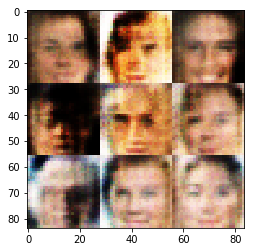

Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 1.4663
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.7321
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 2.1291
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 2.1448... Generator Loss: 0.2055
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 1.1745


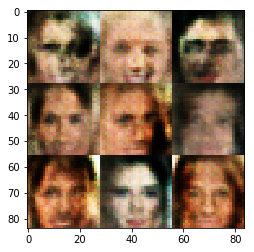

Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 1.4938
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 1.5233
Epoch 1/1... Discriminator Loss: 1.7109... Generator Loss: 0.3173
Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 2.0959
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.3486
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 1.1532


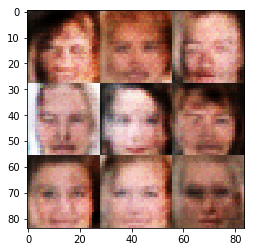

Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.1061
Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 1.4025
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.9646... Generator Loss: 0.2198
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 2.6280


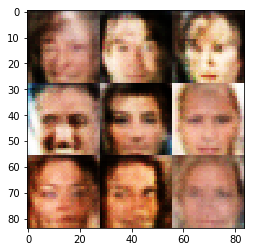

Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.4138
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 1.3637
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.3743
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.2150
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 2.2768
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 0.5326... Generator Loss: 1.5424


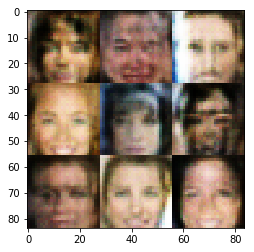

Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.3932
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 1.3929
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 2.0394... Generator Loss: 0.1762
Epoch 1/1... Discriminator Loss: 2.0537... Generator Loss: 0.2052
Epoch 1/1... Discriminator Loss: 1.7133... Generator Loss: 0.2744
Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 1.7020... Generator Loss: 0.2793
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 3.7871
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 1.0048


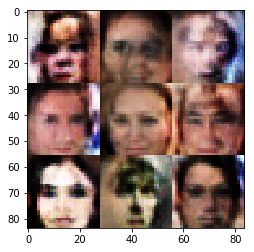

Epoch 1/1... Discriminator Loss: 0.4303... Generator Loss: 1.3588
Epoch 1/1... Discriminator Loss: 0.4927... Generator Loss: 1.7729
Epoch 1/1... Discriminator Loss: 0.2232... Generator Loss: 2.0648
Epoch 1/1... Discriminator Loss: 1.8105... Generator Loss: 0.2672
Epoch 1/1... Discriminator Loss: 2.4720... Generator Loss: 0.1327
Epoch 1/1... Discriminator Loss: 0.1545... Generator Loss: 4.2117
Epoch 1/1... Discriminator Loss: 0.2129... Generator Loss: 6.7977
Epoch 1/1... Discriminator Loss: 0.1217... Generator Loss: 4.0951
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 9.4427
Epoch 1/1... Discriminator Loss: 0.0765... Generator Loss: 4.3530


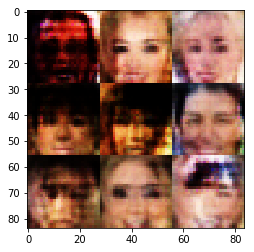

Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 0.0600... Generator Loss: 4.6267
Epoch 1/1... Discriminator Loss: 0.1749... Generator Loss: 2.9122
Epoch 1/1... Discriminator Loss: 0.0319... Generator Loss: 6.1276
Epoch 1/1... Discriminator Loss: 0.2950... Generator Loss: 1.8955
Epoch 1/1... Discriminator Loss: 0.3660... Generator Loss: 1.5631
Epoch 1/1... Discriminator Loss: 0.0820... Generator Loss: 5.8063
Epoch 1/1... Discriminator Loss: 0.2684... Generator Loss: 5.0080
Epoch 1/1... Discriminator Loss: 0.4953... Generator Loss: 1.2773
Epoch 1/1... Discriminator Loss: 0.2825... Generator Loss: 1.8690


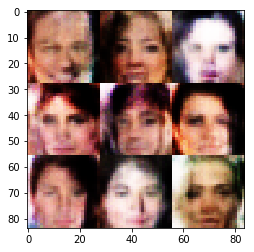

Epoch 1/1... Discriminator Loss: 0.0705... Generator Loss: 5.1419
Epoch 1/1... Discriminator Loss: 1.9205... Generator Loss: 0.2820
Epoch 1/1... Discriminator Loss: 0.5902... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 0.0266... Generator Loss: 5.6379
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 0.0833... Generator Loss: 6.1566
Epoch 1/1... Discriminator Loss: 0.0698... Generator Loss: 3.3429
Epoch 1/1... Discriminator Loss: 0.0423... Generator Loss: 6.5402
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 4.5997
Epoch 1/1... Discriminator Loss: 0.0706... Generator Loss: 8.2233


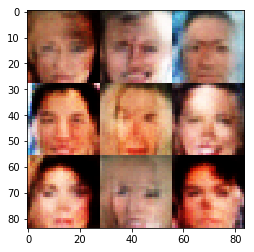

Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 5.7889
Epoch 1/1... Discriminator Loss: 0.0545... Generator Loss: 4.8840
Epoch 1/1... Discriminator Loss: 0.3083... Generator Loss: 4.7402
Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 4.6920
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 4.2827
Epoch 1/1... Discriminator Loss: 2.2509... Generator Loss: 0.1829
Epoch 1/1... Discriminator Loss: 0.0996... Generator Loss: 5.0193
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 0.1652... Generator Loss: 2.2964


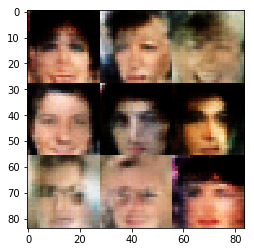

Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 5.9642
Epoch 1/1... Discriminator Loss: 0.0476... Generator Loss: 4.9810
Epoch 1/1... Discriminator Loss: 0.1325... Generator Loss: 4.4249
Epoch 1/1... Discriminator Loss: 0.0745... Generator Loss: 4.1244
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 7.3077
Epoch 1/1... Discriminator Loss: 0.0589... Generator Loss: 5.3565
Epoch 1/1... Discriminator Loss: 0.0667... Generator Loss: 6.6042
Epoch 1/1... Discriminator Loss: 0.0951... Generator Loss: 3.2144
Epoch 1/1... Discriminator Loss: 0.1232... Generator Loss: 2.5508
Epoch 1/1... Discriminator Loss: 0.0749... Generator Loss: 7.4437


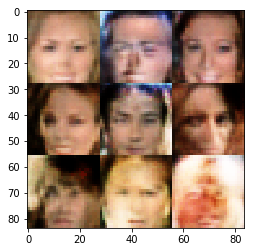

Epoch 1/1... Discriminator Loss: 0.1439... Generator Loss: 3.7646
Epoch 1/1... Discriminator Loss: 0.2682... Generator Loss: 3.2746
Epoch 1/1... Discriminator Loss: 0.0948... Generator Loss: 4.9084
Epoch 1/1... Discriminator Loss: 0.0762... Generator Loss: 5.2086
Epoch 1/1... Discriminator Loss: 0.0244... Generator Loss: 4.9215
Epoch 1/1... Discriminator Loss: 0.0239... Generator Loss: 6.7435
Epoch 1/1... Discriminator Loss: 0.0738... Generator Loss: 3.2833
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 10.8869
Epoch 1/1... Discriminator Loss: 1.7607... Generator Loss: 2.0245
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 1.0659


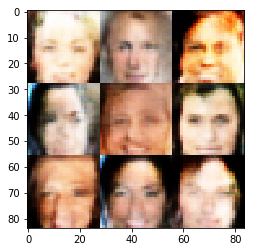

Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.7369
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.2582
Epoch 1/1... Discriminator Loss: 1.8810... Generator Loss: 0.2328
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.2223
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.3741
Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 1.2658


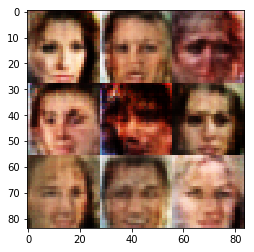

Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.4447
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 0.5703... Generator Loss: 2.0319
Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.4108
Epoch 1/1... Discriminator Loss: 1.8886... Generator Loss: 0.2815
Epoch 1/1... Discriminator Loss: 0.6702... Generator Loss: 1.5325


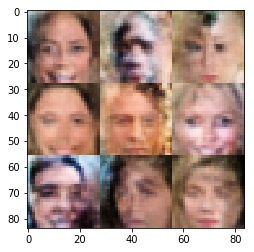

Epoch 1/1... Discriminator Loss: 0.7632... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 1.3691
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 1.2233
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 2.6039
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 2.6085
Epoch 1/1... Discriminator Loss: 0.4356... Generator Loss: 1.4540
Epoch 1/1... Discriminator Loss: 2.3882... Generator Loss: 0.1422
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 1.7796
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 3.1347


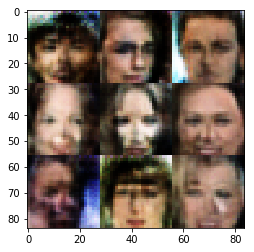

Epoch 1/1... Discriminator Loss: 0.5769... Generator Loss: 1.3028
Epoch 1/1... Discriminator Loss: 0.3653... Generator Loss: 3.4987
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.3663
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.4914
Epoch 1/1... Discriminator Loss: 0.2661... Generator Loss: 2.0930
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 0.2544... Generator Loss: 4.7099
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.3722
Epoch 1/1... Discriminator Loss: 0.1055... Generator Loss: 3.4464
Epoch 1/1... Discriminator Loss: 0.2030... Generator Loss: 2.4866


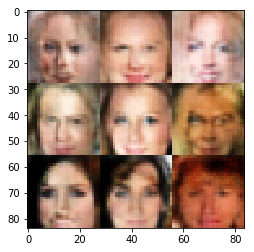

Epoch 1/1... Discriminator Loss: 0.1183... Generator Loss: 5.6896
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.3223
Epoch 1/1... Discriminator Loss: 0.2747... Generator Loss: 4.1728
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 0.2204... Generator Loss: 2.0039
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 4.8214
Epoch 1/1... Discriminator Loss: 0.3007... Generator Loss: 7.7434
Epoch 1/1... Discriminator Loss: 0.0459... Generator Loss: 5.2774
Epoch 1/1... Discriminator Loss: 0.0449... Generator Loss: 9.7286
Epoch 1/1... Discriminator Loss: 0.1058... Generator Loss: 2.7560


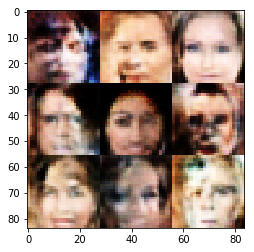

Epoch 1/1... Discriminator Loss: 0.1671... Generator Loss: 4.8876
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 6.0377
Epoch 1/1... Discriminator Loss: 1.6473... Generator Loss: 3.7619
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 1.8050
Epoch 1/1... Discriminator Loss: 0.2381... Generator Loss: 1.9047
Epoch 1/1... Discriminator Loss: 0.1369... Generator Loss: 2.8684
Epoch 1/1... Discriminator Loss: 0.0965... Generator Loss: 3.1546
Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 0.2121... Generator Loss: 2.2571
Epoch 1/1... Discriminator Loss: 2.3118... Generator Loss: 0.1706


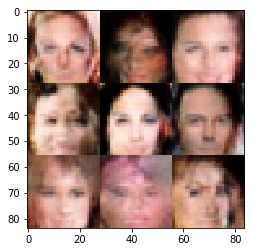

Epoch 1/1... Discriminator Loss: 0.1286... Generator Loss: 3.6485
Epoch 1/1... Discriminator Loss: 2.9691... Generator Loss: 6.5409
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.8376... Generator Loss: 0.2455
Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 1.2582
Epoch 1/1... Discriminator Loss: 0.0677... Generator Loss: 3.4904
Epoch 1/1... Discriminator Loss: 0.2642... Generator Loss: 1.9697
Epoch 1/1... Discriminator Loss: 0.1312... Generator Loss: 6.2961
Epoch 1/1... Discriminator Loss: 0.2824... Generator Loss: 1.8315
Epoch 1/1... Discriminator Loss: 0.0931... Generator Loss: 3.2588


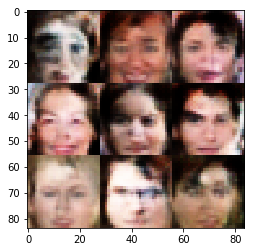

Epoch 1/1... Discriminator Loss: 1.8094... Generator Loss: 4.7167
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.5701... Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 0.1824... Generator Loss: 3.6607
Epoch 1/1... Discriminator Loss: 0.1336... Generator Loss: 4.1237
Epoch 1/1... Discriminator Loss: 0.1865... Generator Loss: 2.3434
Epoch 1/1... Discriminator Loss: 3.6479... Generator Loss: 3.7503
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 0.2035... Generator Loss: 2.9109


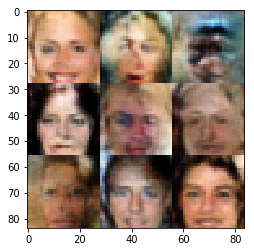

Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 1.8562
Epoch 1/1... Discriminator Loss: 0.2935... Generator Loss: 1.8023
Epoch 1/1... Discriminator Loss: 0.1871... Generator Loss: 4.5213
Epoch 1/1... Discriminator Loss: 0.1854... Generator Loss: 2.8363
Epoch 1/1... Discriminator Loss: 0.1452... Generator Loss: 5.1215
Epoch 1/1... Discriminator Loss: 0.1359... Generator Loss: 6.4445
Epoch 1/1... Discriminator Loss: 0.1250... Generator Loss: 3.8685
Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 1.4818
Epoch 1/1... Discriminator Loss: 0.1454... Generator Loss: 2.6679
Epoch 1/1... Discriminator Loss: 0.0491... Generator Loss: 3.7879


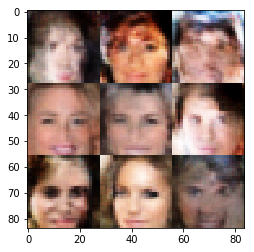

Epoch 1/1... Discriminator Loss: 1.7760... Generator Loss: 0.3069
Epoch 1/1... Discriminator Loss: 1.6953... Generator Loss: 0.3132
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 0.1448... Generator Loss: 3.9616
Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 0.1651... Generator Loss: 4.4251
Epoch 1/1... Discriminator Loss: 0.0805... Generator Loss: 3.5291
Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 4.8749
Epoch 1/1... Discriminator Loss: 3.3249... Generator Loss: 4.3762
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 2.6876


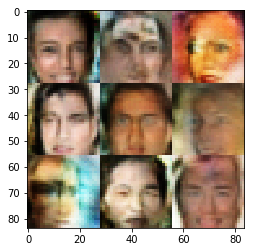

Epoch 1/1... Discriminator Loss: 0.2600... Generator Loss: 2.7260
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 0.1689... Generator Loss: 3.7164
Epoch 1/1... Discriminator Loss: 0.1057... Generator Loss: 3.0481
Epoch 1/1... Discriminator Loss: 0.0650... Generator Loss: 3.6968
Epoch 1/1... Discriminator Loss: 0.0508... Generator Loss: 6.7297
Epoch 1/1... Discriminator Loss: 0.1683... Generator Loss: 2.7808
Epoch 1/1... Discriminator Loss: 0.0281... Generator Loss: 4.7037
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 1.2961
Epoch 1/1... Discriminator Loss: 2.0125... Generator Loss: 4.4867


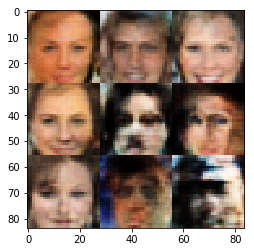

Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 0.2640... Generator Loss: 1.8918
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 0.4163... Generator Loss: 1.4313
Epoch 1/1... Discriminator Loss: 0.0843... Generator Loss: 4.3407
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 1.2414
Epoch 1/1... Discriminator Loss: 0.2209... Generator Loss: 2.1143
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 6.4215
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 4.0652


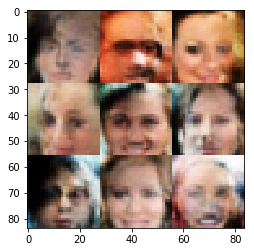

Epoch 1/1... Discriminator Loss: 1.8258... Generator Loss: 0.3061
Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 1.6524
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 3.8943
Epoch 1/1... Discriminator Loss: 1.6016... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 0.3305... Generator Loss: 1.6906
Epoch 1/1... Discriminator Loss: 0.1834... Generator Loss: 2.3525
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.3085
Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 2.1700
Epoch 1/1... Discriminator Loss: 0.1347... Generator Loss: 2.9575
Epoch 1/1... Discriminator Loss: 0.3242... Generator Loss: 2.5258


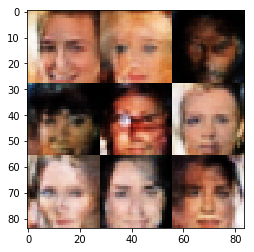

Epoch 1/1... Discriminator Loss: 0.0847... Generator Loss: 4.0927
Epoch 1/1... Discriminator Loss: 0.3100... Generator Loss: 1.7743
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 1.2870
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 0.6609... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 1.2919
Epoch 1/1... Discriminator Loss: 0.1040... Generator Loss: 4.6890
Epoch 1/1... Discriminator Loss: 0.2040... Generator Loss: 2.2622
Epoch 1/1... Discriminator Loss: 0.0621... Generator Loss: 3.8721
Epoch 1/1... Discriminator Loss: 0.1695... Generator Loss: 2.4963


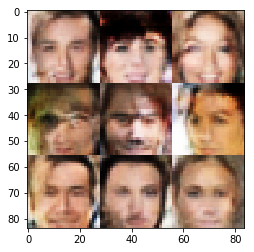

Epoch 1/1... Discriminator Loss: 0.1361... Generator Loss: 6.7199
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 1.3067
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.1134
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 1.5029
Epoch 1/1... Discriminator Loss: 0.2721... Generator Loss: 4.6327
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 3.5701
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 0.6312... Generator Loss: 1.0917


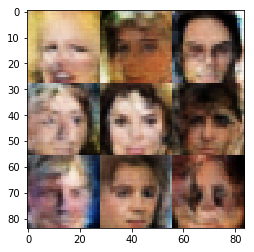

Epoch 1/1... Discriminator Loss: 2.3684... Generator Loss: 4.4123
Epoch 1/1... Discriminator Loss: 0.1012... Generator Loss: 3.2506
Epoch 1/1... Discriminator Loss: 0.4391... Generator Loss: 3.4399
Epoch 1/1... Discriminator Loss: 0.1374... Generator Loss: 3.0899
Epoch 1/1... Discriminator Loss: 0.2370... Generator Loss: 2.2278
Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.7210


In [ ]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.